In [8]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import folium

# Load data from CSV file
csv_file_path = 'G:/Data/Python Project/foursquare.csv'
merge_all_data = pd.read_csv(csv_file_path)

# Check the first 5 rows of the data
print(merge_all_data.head())

# Drop duplicate rows
merge_all_data = merge_all_data.drop_duplicates()

# Drop rows with missing values
merge_all_data = merge_all_data.dropna()

# Save the cleaned data to a new CSV file
output_csv_path = Path('G:/Data/Python Project/EDA_data.csv')
output_csv_path.parent.mkdir(parents=True, exist_ok=True)
merge_all_data.to_csv(output_csv_path, index=False)

# Check the data types of each column
print("Data types of each column:")
print(merge_all_data.dtypes)

# Check for duplicate rows
duplicate_rows_df = merge_all_data[merge_all_data.duplicated()]
print("Number of duplicate rows:", duplicate_rows_df.shape[0])

# Check for missing values
print("Number of missing values in each column:")
print(merge_all_data.isnull().sum())

# Check the data after removing duplicates and missing values
print("Data after removing duplicates and missing values:")
print(merge_all_data.head())

   Unnamed: 0                    fsq_id  category_id   category_name  \
0           0  4b65b9f1f964a520fefb2ae3        13031    Burger Joint   
1           1  4d0cef321f6bf04d75707a31        16037      Playground   
2           2  4deb8ba688774880e3387c0c        17065  Farmers Market   
3           3  4fdbc663e4b029940a58c201        16049       Surf Spot   
4           4  4be3345b660ec928226dcb3b        16017          Garden   

                                              chains  distance   latitude  \
0  [{'id': 'ab4a3530-d68a-012e-5619-003048cad9da'...        62  43.665065   
1                                                 []        63  43.664679   
2                                                 []        40  43.664679   
3                                                 []       153  43.664482   
4                                                 []       173  43.665243   

   longitude location_country           location_cross_street  \
0 -79.319000               CA  btw Quee

In [9]:
#importing csv files from previous notebooks

citybike_df = pd.read_csv('G:/Data/Python Project/citybike.csv',index_col=0)
#citybike_df.head()

foursquare_df = pd.read_csv('G:/Data/Python Project/EDA_data.csv',index_col=0)
#foursquare_df.head()


yelp_df = pd.read_csv('G:/Data/Python Project/yelp.csv',index_col=0)
#yelp_df.head()


In [10]:
def round_coordinates(df, decimals=3):

# Rounds the latitude and longitude of a given DataFrame.

    df['latitude'] = df['latitude'].round(decimals)
    df['longitude'] = df['longitude'].round(decimals)
    return df

# Trim latitude and longitude to increase join match
citybike_df = round_coordinates(citybike_df)
foursquare_df = round_coordinates(foursquare_df)
yelp_df = round_coordinates(yelp_df)

# Merge multiple dataframes
merged_df = pd.merge(citybike_df, foursquare_df, on=['latitude', 'longitude'], how='outer')
merged_df = pd.merge(merged_df, yelp_df, on=['latitude', 'longitude'], how='outer')

# Remove duplicate entries
merged_df = merged_df.drop_duplicates(subset=['latitude', 'longitude', 'fsq_id'], keep='last')

# Show the head of the final merged dataframe
merged_df.head()

,name_x,latitude,longitude,bikes_available,fsq_id,category_id,category_name,chains,distance_x,location_country,...,location_postcode,location_region,location_timezone,name_y,name,rating,review_count,price,distance_y,category
19,Queen St E / Woodward Ave,43.665,-79.320,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Regency Restaurant,4.0,78.0,$$,779.013046,NaN
39,Primrose Ave / Davenport Rd,43.671,-79.446,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,The Caledonian,4.5,152.0,$$,2619.251867,NaN
59,Queen St. E / Rhodes Ave.,43.666,-79.318,3.0,4e1d9859b0fb93d2d06393c1,11134.0,Pet Grooming Service,[],64.0,CA,...,M4L 1G1,ON,America/Toronto,Canine Clips,Yaya Greek Bistro,4.0,83.0,$$,1186.567477,NaN
79,Bond St / Queen St E,43.653,-79.377,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Adega Restaurante,4.0,161.0,$$$,692.748189,NaN
99,Church St / Alexander St,43.664,-79.380,4.0,4ad9fc4bf964a520c81c21e3,11045.0,Bank,[{'id': 'd5192150-d890-0132-61d3-7a163eb2a6fc'...,5.0,CA,...,M4Y 2C8,ON,America/Toronto,BMO Bank of Montreal,The Carbon Bar,4.0,411.0,$$$,1252.214295,NaN


In [15]:
import folium

def create_bike_location_map(df, location_cols, popup_col, zoom_start=13):

#  Create a folium Map and add markers.

    if not set(location_cols + [popup_col]).issubset(df.columns):
        raise ValueError("One or more column names are not in the DataFrame")

    # Create the map centered on the mean coordinates
    center_lat = df[location_cols[0]].mean()
    center_lng = df[location_cols[1]].mean()
    bike_location_map = folium.Map(location=[center_lat, center_lng], zoom_start=zoom_start)

    # Add a marker for each location
    for _, row in df.iterrows():
        location = [row[col] for col in location_cols]
        popup_text = f"{popup_col}: {row[popup_col]}"
        folium.Marker(location=location, popup=popup_text).add_to(bike_location_map)

    return bike_location_map

# Create a map with markers for the bike locations
bike_location_map = create_bike_location_map(merged_df, ['latitude', 'longitude'], 'bikes_available')

# Display the map
bike_location_map


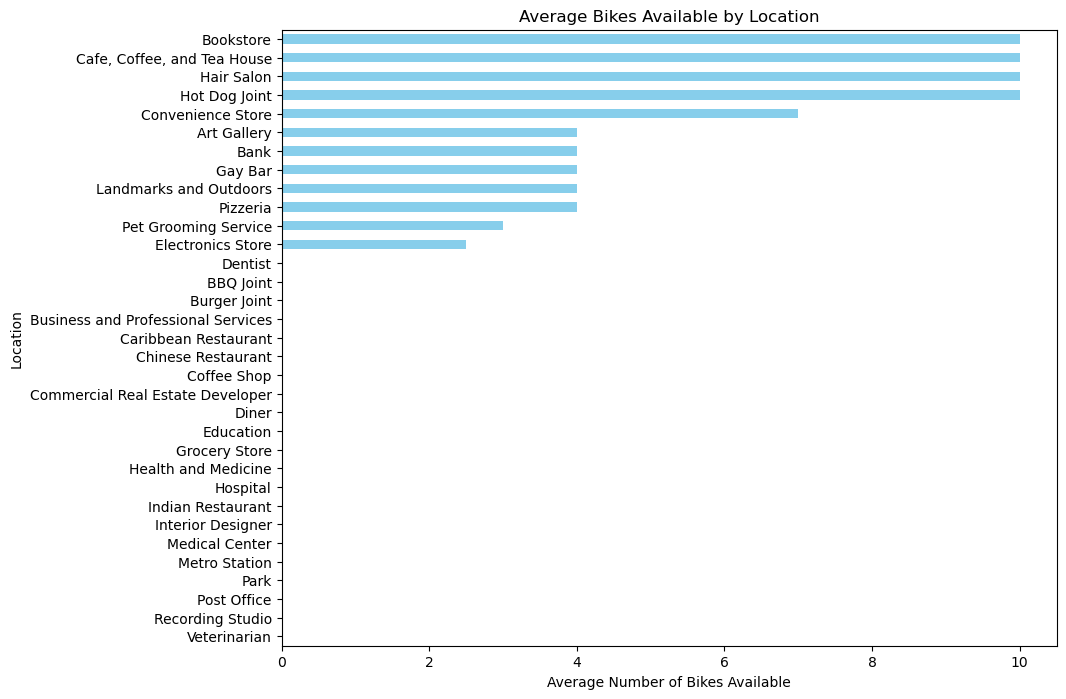

In [20]:
import matplotlib.pyplot as plt

def plot_average_bikes(df, group_col, value_col, figsize=(10, 8), color='skyblue'):
 #plot a sorted bar chart.

    if not set([group_col, value_col]).issubset(df.columns):
        raise ValueError("One or more column names are not in the DataFrame")

    grouped = df.groupby(group_col)[value_col].mean().sort_values(ascending=False)

    plt.figure(figsize=figsize)
    grouped.plot(kind='barh', color=color)
    plt.xlabel('Average Number of Bikes Available')
    plt.ylabel('Location')
    plt.title('Average Bikes Available by Location')
    plt.gca().invert_yaxis()  # Reverse the order of the y-axis
    plt.show()

# Call the function to plot average bikes available by location
plot_average_bikes(merged_df, 'category_name', 'bikes_available')


<Figure size 800x600 with 0 Axes>

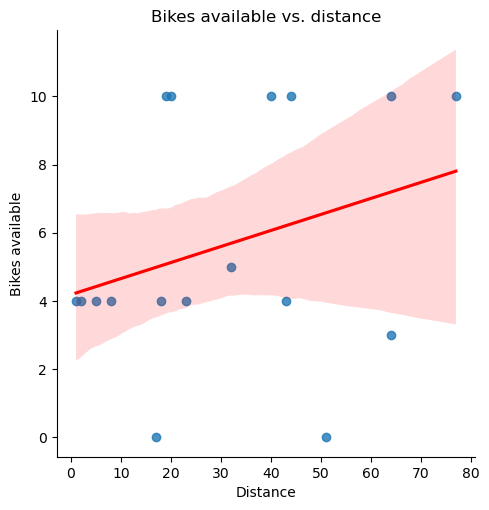

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_scatter_with_regression(df, x_col, y_col, figsize=(8, 6)):

   # Plot a scatter chart with a regression line with the specified DataFrame, x column, and y column.

    if not set([x_col, y_col]).issubset(df.columns):
        raise ValueError("One or more column names are not in the DataFrame")

    plt.figure(figsize=figsize)
    sns.regplot(x=x_col, y=y_col, data=df, line_kws={'color': 'red'})
    plt.xlabel('Distance')
    plt.ylabel('Bikes available')
    plt.title('Bikes available vs. distance')
    plt.show()

# Call the function to plot bikes available versus distance
plot_scatter_with_regression(merged_df, 'distance_x', 'bikes_available')


In [21]:
import sqlite3

# Connect to an SQLite database in a specific directory
conn = sqlite3.connect('G:/Data/Python Project/database.sqlite')

# Store the Pandas dataframe into the SQLite database
merged_df.to_sql('merged_data', conn, if_exists='replace')

# Write the SQL query
query = "SELECT * FROM merged_data"

# Use pd.read_sql_query to query the database and put the result into a DataFrame
df = pd.read_sql_query(query, conn)

# Display the DataFrame
print(df)

# Remember to close the connection when done
conn.close()

     index                       name_x  latitude  longitude  bikes_available  \
0       19    Queen St E / Woodward Ave    43.665    -79.320              6.0   
1       39  Primrose Ave / Davenport Rd    43.671    -79.446              5.0   
2       59    Queen St. E / Rhodes Ave.    43.666    -79.318              3.0   
3       79         Bond St / Queen St E    43.653    -79.377              2.0   
4       99     Church St / Alexander St    43.664    -79.380              4.0   
..     ...                          ...       ...        ...              ...   
686   1042                         None    43.676    -79.390              NaN   
687   1043                         None    43.674    -79.390              NaN   
688   1044                         None    43.675    -79.397              NaN   
689   1045                         None    43.675    -79.397              NaN   
690   1046                         None    43.674    -79.396              NaN   

                       fsq_